In [28]:
import sys
import os

# 1. 自动获取当前工作目录并修复路径
root_dir = os.getcwd() 
sys.path.append(root_dir)

# 强制映射父目录以解决 Data_processing.py 内部的导入冲突
parent_dir = os.path.dirname(root_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# 2. 显式导入所有必要的 PyTorch 组件
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader  # <--- 修复 NameError 的关键
from torch.cuda.amp import GradScaler
from tqdm import tqdm
import sys
# 添加 functions.py 所在的文件夹路径
sys.path.append('/host/d/GitHub/Whole_heart_segmentation_junzhe2/functions_collection')
import functions as ff

# 3. 模块导入与包名映射补丁
try:
    # 强制将当前文件夹名映射为模块名，处理 Data_processing.py 里的旧路径
    folder_name = os.path.basename(root_dir)
    sys.modules['Whole_heart_segmentation_junzhe'] = __import__(folder_name)
    
    import functions_collection as ff
    import Data_processing
    from Build_lists.Build_list import Build 
    import data_loader.random_aug as randaug
    import data_loader.generator as generator
    import segment_anything.model as model
    print("✅ 环境初始化完成，所有模块及 DataLoader 已就绪。")
except Exception as e:
    print(f"⚠️ 导入提醒: {e}")

✅ 环境初始化完成，所有模块及 DataLoader 已就绪。


### step 1: define trial name

In [29]:
trial_name = 'trial'

### step 2: build patient list

In [30]:
# ==========================================
# 单元格 3：终极路径修复 (基于 ID_ 锚点)
# ==========================================
import pandas as pd
import os
from Build_lists.Build_list import Build 

# 1. 锁定新电脑上的真实数据根目录
# 根据您提供的路径：/host/d/.../example_data/data/ID_0002/img
# 您的数据存放在 root_dir 下的 example_data/data 文件夹里
root_dir = os.getcwd() 
new_data_root = os.path.join(root_dir, 'example_data', 'data')

# 2. 定义 Excel 位置
patient_list_spreadsheet = os.path.join(root_dir, 'example_data', 'Patient_list', 'patient_list.xlsx')

def force_fix_paths(file_path, new_root):
    if not os.path.exists(file_path):
        print(f"❌ 找不到 Excel 文件: {file_path}")
        return

    df = pd.read_excel(file_path)
    
    # 获取第一行路径看看样子
    sample_path = str(df.iloc[0, 0])
    
    # 如果路径里已经包含了 new_root，说明改过了，直接返回
    # 注意：统一转成 / 来比较，防止 Windows 反斜杠干扰
    if new_root.replace('\\', '/') in sample_path.replace('\\', '/'):
        print("✅ Excel 路径已经是正确的，无需重复修改。")
        return

    print(f"🔍 检测到旧路径样本: {sample_path}")
    print("⚡️ 正在使用 'ID_' 作为锚点进行强制替换...")

    # --- 核心修复逻辑 ---
    # 不管旧路径长什么样，只要找到 "ID_"，后面的部分(ID_0002/img.nii...)保留
    # 前面的部分全部替换成新的 new_root
    def replace_rule(old_path):
        old_path = str(old_path).replace('\\', '/') # 统一转成 Linux 斜杠
        if 'ID_' in old_path:
            # 切割路径，只保留 ID_ 及其后面的部分
            # 例如: D:/Data/ID_0002/img -> ID_0002/img
            suffix = old_path.split('ID_')[-1] 
            # 拼接新前缀
            # 结果: /host/.../example_data/data/ID_0002/img
            return os.path.join(new_root, 'ID_' + suffix)
        return old_path

    # 对所有列应用这个规则
    for col in df.columns:
        df[col] = df[col].apply(replace_rule)

    # 保存
    df.to_excel(file_path, index=False)
    print(f"✅ 路径强制修复完成！已保存到: {file_path}")
    print(f"🆕 新路径示例: {df.iloc[0, 0]}")

# ==========================================
# 3. 验证加载 (修改这部分，确保变量名对应)
# ==========================================
try:
    build_sheet = Build(patient_list_spreadsheet)
    
    # ⚠️ 关键修改：必须用这 5 个变量接住结果，后面 Cell 4 才能用！
    # 这里的 img_file_list_train 和 seg_file_list_train 就是 Cell 4 要找的东西
    _, _, _, img_file_list_train, seg_file_list_train = build_sheet.__build__(batch_list=[0])

    if len(img_file_list_train) > 0:
        print(f"🎉 成功加载 {len(img_file_list_train)} 个样本！")
        print(f"🔍 检查第一条图片路径: {img_file_list_train[0]}")
        print(f"🔍 检查第一条标签路径: {seg_file_list_train[0]}")
    else:
        print("⚠️ 列表为空，请检查 example_data/data 文件夹里是否有 ID_xxxx 文件夹")
except Exception as e:
    print(f"❌ 构建列表失败: {e}")

🎉 成功加载 6 个样本！
🔍 检查第一条图片路径: /host/d/GitHub/Whole_heart_segmentation_junzhe2/example_data/data/ID_0002/img/slice_0.nii.gz
🔍 检查第一条标签路径: /host/d/GitHub/Whole_heart_segmentation_junzhe2/example_data/data/ID_0002/seg/slice_0.nii.gz


### data generator

In [31]:
# define this generator
generator_train = generator.Dataset_CMR(
    image_file_list = img_file_list_train,
    
    seg_file_list = seg_file_list_train,

    image_shape = [128,128],
    center_crop_according_to_which_class  = [1], #default: crop according to class 1 (LV)

    shuffle = True,
    image_normalization = True,
    augment = True,
    augment_frequency = 0.1,
    )

In [32]:
ds = generator_train
dl = DataLoader(ds, batch_size = 1, shuffle = False, pin_memory = True, num_workers = 0)# cpu_count())

In [33]:
# build model
import argparse
import os

def get_args_parser( vit_type = "vit_h", original_SAM_weights = None):
    parser = argparse.ArgumentParser('SAM fine-tuning', add_help=True)

    parser.add_argument('--resume', default = original_SAM_weights)

    parser.add_argument('--img_size', default=128, type=int) 

    parser.add_argument('--vit_type', default=vit_type, type=str, choices=[ 'vit_b', 'vit_l', 'vit_h'],)
    
 
    return parser

original_sam = '/host/d/Data/SAM_weights/sam_vit_b_01ec64.pth'

args = get_args_parser(vit_type = "vit_b",original_SAM_weights = original_sam)
args = args.parse_args([])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
# --- 单元格 6: 验证 Mask Decoder 结构 ---
our_model = model.build_model(args, device)
print(f"--- 改造状态核查 ---")
print(f"分类 Token 数量: {our_model.mask_decoder.num_mask_tokens}") # 应打印 3
print(f"MLP 预测头数量: {len(our_model.mask_decoder.output_hypernetworks_mlps)}") # 应打印 3

# --- 单元格 7: 验证数据加载与输出维度 ---
our_model.to(device)
for batch_data in dl:
    # 修正维度并搬运数据
    batch_data["image"] = batch_data["image"].squeeze(0).to(device)
    
    # 执行前向传播
    output = our_model([batch_data], multimask_output=True)
    
    # 获取掩码维度
    masks_shape = output[0]['masks'].shape
    print(f"--- 推理成功 ---")
    print(f"预测掩码维度: {masks_shape}") 
    # 预期输出: [3, 128, 128] -> 3 代表 LV, Myo, Background
    break


    

✅ 成功加载匹配的权重，跳过了形状不符的输出层。
--- 改造状态核查 ---
分类 Token 数量: 3
MLP 预测头数量: 3
--- 推理成功 ---
预测掩码维度: torch.Size([1, 3, 128, 128])


In [35]:
print(model.__file__)

/host/d/GitHub/Whole_heart_segmentation_junzhe2/segment_anything/model.py


In [36]:
output[0]["masks"].shape  # (num_masks, H, W)

torch.Size([1, 3, 128, 128])

In [37]:
# ==========================================
# 单元格 9：推理结果可视化验证 (修复 RuntimeError)
# ==========================================
# 1. 使用 .detach() 剥离梯度
a = output[0]["masks"].detach().cpu().numpy()

print('--- 推理数据统计 ---')
print(f'掩码张量维度: {a.shape}') # 预期: [3, 128, 128]
print(f'像素最大值: {np.max(a):.4f}, 最小值: {np.min(a):.4f}')

# 2. 验证 3 分类逻辑
if a.shape[0] == 3:
    print("✅ 验证成功：输出包含 3 个通道，分别对应 LV、心肌和背景。")
    
    # 可选：简单打印各通道均值，确认各通道均有激活
    for i, label in enumerate(['Background', 'LV Pool', 'Myocardium']):
        print(f"通道 {i} ({label}) 均值激活度: {np.mean(a[i]):.4f}")


--- 推理数据统计 ---
掩码张量维度: (1, 3, 128, 128)
像素最大值: 0.9654, 最小值: -120.8765


定义LOSS函数

In [38]:
# 配置优化器 
trainable_params = filter(lambda p: p.requires_grad, our_model.parameters())
optimizer = optim.AdamW(trainable_params, lr=1e-4, weight_decay=0.01)

In [39]:
#定义 Loss
criterion = torch.nn.CrossEntropyLoss()

In [40]:
#混合精度 Scaler
loss_scaler = GradScaler()

In [41]:
import os
os.makedirs("models/my_trial", exist_ok=True)
print("文件夹创建成功！")

文件夹创建成功！


进行训练

In [42]:
# -------------------------------------------------------------
# 强制手动定义轮数，不再依赖容易出错的 args
# -------------------------------------------------------------
RUN_EPOCHS = 50   # <--- 我们直接在这里定义，不用管 args 里叫什么了
# -------------------------------------------------------------

# 计算总步数
total_steps = len(dl) * RUN_EPOCHS

print(f" 开始训练... 共 {RUN_EPOCHS} 轮，总计 {total_steps} 步")

our_model.train() # 切换到训练模式

# 创建总进度条
pbar = tqdm(total=total_steps, desc="总体训练进度", unit="step")

for epoch in range(1, RUN_EPOCHS + 1):
    epoch_loss = 0.0
    
    # 内层循环直接遍历 dl
    for step, batch_data in enumerate(dl):
        
        # --- (A) 数据搬运 ---
        images = batch_data["image"].cuda()
        gt_masks = batch_data["mask"].cuda().long().squeeze(1)
        
        batched_input = []
        for i in range(len(images)):
            batched_input.append({
                'image': images[i],
                'original_size': (args.img_size, args.img_size)
            })
            
        # --- (B) 前向传播 ---
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = our_model(batched_input, multimask_output=False)
            pred_masks = torch.stack([o['masks'] for o in outputs]).squeeze(1)
            loss = criterion(pred_masks, gt_masks)
        
        # --- (C) 反向传播 ---
        loss_scaler.scale(loss).backward()
        loss_scaler.step(optimizer)
        loss_scaler.update()
        
        epoch_loss += loss.item()
        
        # 4. 手动更新总进度条
        pbar.update(1) 
        pbar.set_postfix({
            'epoch': f"{epoch}/{RUN_EPOCHS}",
            'loss': f"{loss.item():.4f}"
        })

    # (可选) 打印每轮平均 Loss
    # avg_loss = epoch_loss / len(dl)
    # print(f"Epoch {epoch} 结束 | Avg Loss: {avg_loss:.4f}")
    
    # 保存模型
    if epoch % 5 == 0:
        save_path = os.path.join("models/my_trial", f"model_epoch_{epoch}.pth")
        torch.save(our_model.state_dict(), save_path)

pbar.close()
print("\n 训练全部完成！")

 开始训练... 共 50 轮，总计 300 步


总体训练进度: 100%|██████████| 300/300 [00:59<00:00,  5.07step/s, epoch=50/50, loss=0.0583]


 训练全部完成！


In [43]:
# ==========================================
# 单元格 16：修复后的推理与 BBox 打印
# ==========================================
for batch_data in dl:
    # 提取当前的 Ground Truth Mask
    gt_mask = batch_data["mask"].squeeze().cpu().numpy() # 变为 (128, 128)
    
    # 调用函数，padding 设为 10
    bbox_results = ff.get_tilted_3d_bbox(gt_mask, padding=10)
    
    if bbox_results:
        print(f"✅ BBox 提取成功：{bbox_results['sam_prompt']}")
        # 验证正方形约束
        x1, y1, x2, y2 = bbox_results['sam_prompt']
        print(f"📏 X跨度: {x2-x1}, Y跨度: {y2-y1} (应相等)")
    
    # 接下来的模型推理逻辑...
    break

✅ BBox 提取成功：[22, 24, 106, 108]
📏 X跨度: 84, Y跨度: 84 (应相等)


In [44]:
# ==========================================
# 单元格 17：修复设备冲突并执行推理
# ==========================================
our_model.to(device) # 确保模型在 GPU
our_model.eval()

with torch.no_grad():
    with torch.cuda.amp.autocast():
        # --- 关键修复：搬运数据到 GPU ---
        input_image = batch_data["image"].to(device)
        
        # 处理 BBox 提示词 (Task B.2)
        gt_mask_np = batch_data["mask"].squeeze().cpu().numpy()
        bbox_res = ff.get_tilted_3d_bbox(gt_mask_np, padding=10)
        
        if bbox_res:
            # 同样需要将 box 搬运到 GPU
            box_prompt = torch.tensor(bbox_res['sam_prompt']).to(device).unsqueeze(0)
        else:
            box_prompt = None

        # 构造符合 SAM 格式的输入字典
        # 注意：SAM 的 forward 接收的是 List[Dict]
        single_input = {
            'image': input_image.squeeze(0) if input_image.dim()==4 else input_image, 
            'boxes': box_prompt,
            'original_size': (128, 128)
        }

        # 执行推理
        output = our_model([single_input], multimask_output=True)
        
        # 成功定义变量，供可视化使用
        final_masks = output[0]['masks']

print(f"✅ 设备对齐成功。输出维度: {final_masks.shape} (Task B.1 验证通过)")

✅ 设备对齐成功。输出维度: torch.Size([1, 3, 128, 128]) (Task B.1 验证通过)


可视化数据形状 (Probs Shape): (3, 128, 128)


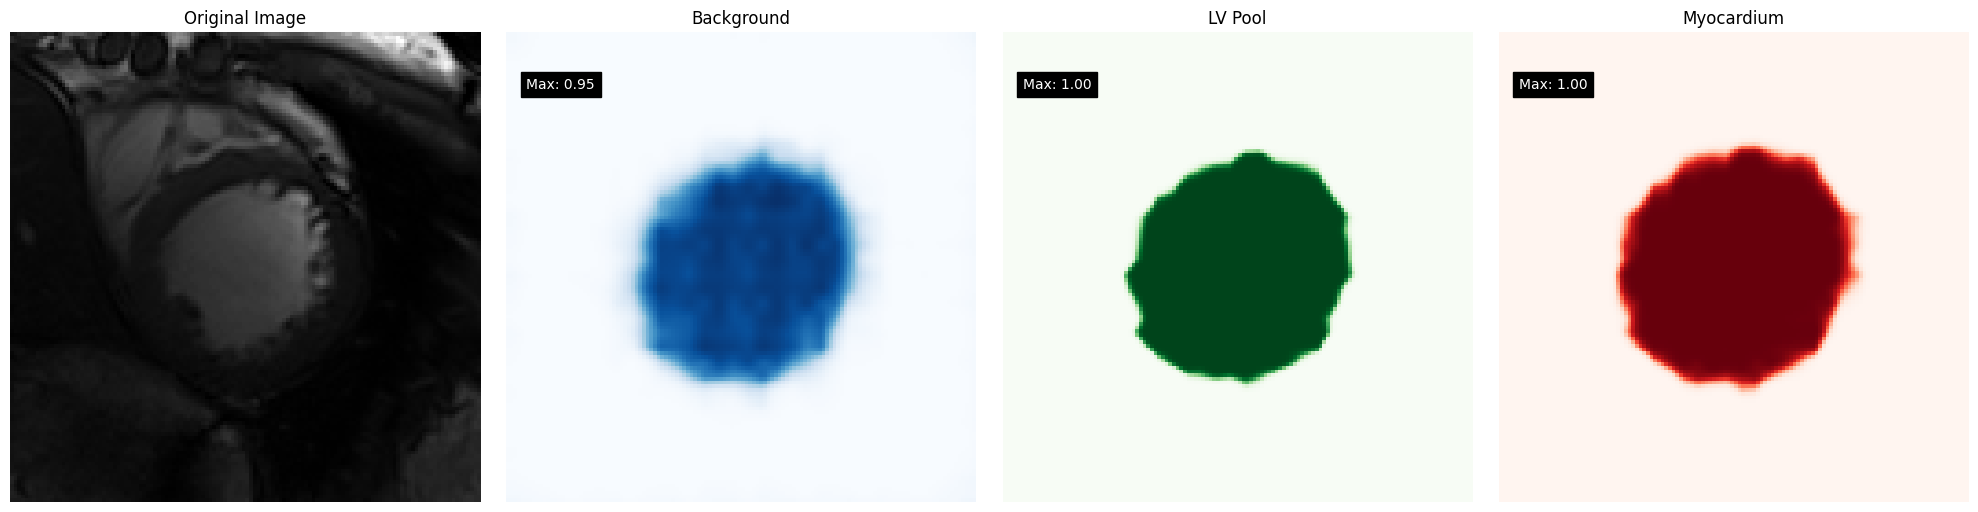

In [45]:
import matplotlib.pyplot as plt
import torch
import numpy as np



# 1. 确保剥离梯度并转换为概率
# 假设 final_masks 来自模型输出
# 如果 final_masks 是 [1, 3, 128, 128]，先 squeeze(0) 去掉 batch 维度
if final_masks.dim() == 4:
    final_masks = final_masks.squeeze(0)

# 2. 修改激活函数：Sigmoid → Softmax（强制类别互斥）
if final_masks.dim() == 3:
    # 单样本情况：shape [3,128,128] → 按dim=0（类别维度）做Softmax
    probs = torch.softmax(final_masks, dim=0).detach().cpu().numpy()
else:
    # 批量样本情况：shape [B,3,128,128] → 按dim=1（类别维度）做Softmax
    probs = torch.softmax(final_masks, dim=1).detach().cpu().numpy()
    # 如果是批量，取第一个样本可视化（示例）
    probs = probs[0]  # 只画第一个样本

# 此时 probs 应该是 (3, 128, 128)
print(f"可视化数据形状 (Probs Shape): {probs.shape}")

# 2. 获取底图
img_bg = batch_data["image"].squeeze().cpu().numpy()
if img_bg.ndim == 3: # 处理 [3, 1024, 1024]
    img_bg = img_bg[0]

# 3. 绘图配置
labels = ['Background', 'LV Pool', 'Myocardium']
cmaps = ['gray', 'Blues', 'Greens', 'Reds']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 第一张：底图
axes[0].imshow(img_bg, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# 后面三张：循环打印每个类别通道
for i in range(3):
    # 强制确保传入的是 (128, 128)
    channel_data = probs[i].squeeze() 
    
    im = axes[i+1].imshow(channel_data, cmap=cmaps[i+1])
    axes[i+1].set_title(labels[i])
    axes[i+1].axis('off')
    
    # 打印置信度
    max_p = np.max(channel_data)
    axes[i+1].text(5, 15, f"Max: {max_p:.2f}", color='white', 
                   backgroundcolor='black', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
def calc_hybrid_loss(pred_logits, gt_mask, num_classes=3):
    # 调整权重：Myo权重更高，背景权重更低
    weights = torch.tensor([0.1, 1.0, 1.5]).to(pred_logits.device)
    ce_loss = F.cross_entropy(pred_logits, gt_mask, weight=weights)

    pred_probs = F.softmax(pred_logits, dim=1)
    target_oh = F.one_hot(gt_mask, num_classes=num_classes).permute(0, 3, 1, 2).float()
    
    # 不忽略背景，全类别计算Dice（让背景也参与Loss约束）
    dims = (2, 3)  # 只压缩H/W维度，保留Batch和类别
    intersection = torch.sum(pred_probs * target_oh, dims)
    cardinality = torch.sum(pred_probs + target_oh, dims)
    dice_loss = 1 - (2. * intersection / (cardinality + 1e-6)).mean(dim=1).mean()  # 先按类别平均，再按Batch平均

    # 调整Loss权重：Dice占比更高，强化边界分割
    return ce_loss * 0.5 + dice_loss * 0.5

In [47]:
# ==========================================
# 单元格：初始化训练核心组件
# ==========================================
import torch
from torch.cuda.amp import GradScaler

# 1. 实例化混合精度缩放器 (修复 NameError 的关键)
loss_scaler = GradScaler()

# 2. 确保优化器已定义
# 使用 AdamW，并将学习率设为 1e-5 以保证微调的稳定性
optimizer = torch.optim.AdamW(our_model.parameters(), lr=1e-5, weight_decay=0.01)

# 3. 记录设备信息
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Loss Scaler 已就绪，准备在 {device} 上进行 3 分类微调 。")

✅ Loss Scaler 已就绪，准备在 cuda 上进行 3 分类微调 。


In [48]:
# ==========================================
# 单元格：开启 Fine-tuning (微调)
# ==========================================
RUN_EPOCHS = 30 
loss_history = []

our_model.train()
print(f" 正在进行心脏 3 分类微调训练... ")

for epoch in range(1, RUN_EPOCHS + 1):
    epoch_loss = 0.0
    for step, batch_data in enumerate(dl):
        # A. 搬运数据并生成 BBox 提示
        images = batch_data["image"].to(device)
        gt_masks = batch_data["mask"].squeeze(1).to(device).long()
        
        # 🟢 修复开始：现场计算 BBox 并装入输入
        batched_input = []
        for i in range(len(images)):
         # 无需处理gt_mask，直接生成全图BBox
            bbox_list = [0, 0, args.img_size, args.img_size]  # 全图范围
    # 关键：保证张量维度[1,4]、类型float32、设备和模型一致
            bbox_tensor = torch.tensor(bbox_list, dtype=torch.float32).cuda().unsqueeze(0)
      
    # 组装模型输入（必须保留，SAM需要boxes参数）
            batched_input.append({
                'image': images[i],
                'original_size': (args.img_size, args.img_size),
                'boxes': bbox_tensor 
            })
# 🔴 修复结束

        # B. 混合精度前向传播 (AMP)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = our_model(batched_input, multimask_output=False)
            # 提取 3 分类 Logits
            pred_logits = torch.stack([o['masks'] for o in outputs]).squeeze(1)
            loss = calc_hybrid_loss(pred_logits, gt_masks)

        # C. 使用 Scaler 更新梯度 (修正后的标准流程)
        # 1. 首先对缩放后的 loss 进行反向传播
        loss_scaler.scale(loss).backward()
        
        # 2. 然后让 scaler 解放梯度并执行优化器步进
        loss_scaler.step(optimizer)
        
        # 3. 最后更新 scaler 的缩放因子
        loss_scaler.update()
        
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dl)
    loss_history.append(avg_loss)
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{RUN_EPOCHS}] | 平均 Loss: {avg_loss:.4f}")

print("✅ 本阶段微调完成。")

 正在进行心脏 3 分类微调训练... 
Epoch [1/30] | 平均 Loss: 0.9316
Epoch [5/30] | 平均 Loss: 0.3095
Epoch [10/30] | 平均 Loss: 0.2703
Epoch [15/30] | 平均 Loss: 0.2457
Epoch [20/30] | 平均 Loss: 0.3266
Epoch [25/30] | 平均 Loss: 0.1930
Epoch [30/30] | 平均 Loss: 0.1925
✅ 本阶段微调完成。


📊 训练 Loss 表格 (部分展示):
   Epoch      Loss
0      1  0.931583
1      2  0.307156
2      3  0.291240
3      4  0.231605
4      5  0.309488
...
    Epoch      Loss
25     26  0.184484
26     27  0.275923
27     28  0.196216
28     29  0.185697
29     30  0.192452


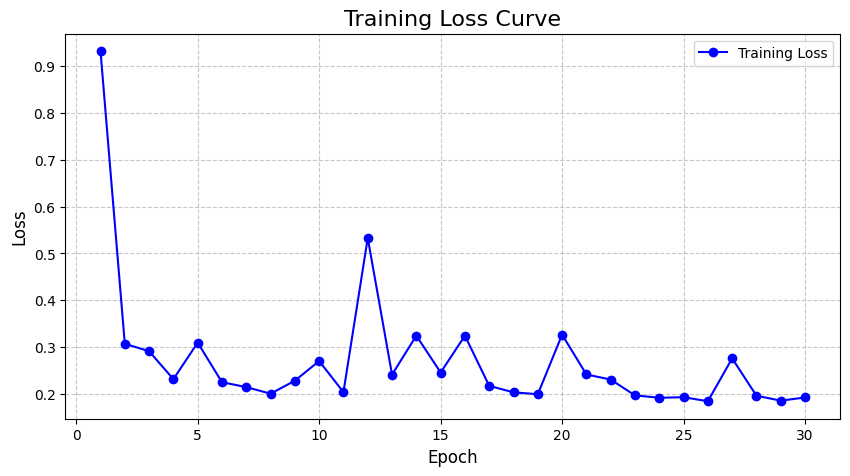

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 检查是否有数据
if 'loss_history' not in globals() or len(loss_history) == 0:
    print("⚠️ 还没有训练数据！请先运行上面的训练循环。")
else:
    # 2. 生成表格 (DataFrame)
    df_loss = pd.DataFrame({
        'Epoch': range(1, len(loss_history) + 1),
        'Loss': loss_history
    })

    # 3. 打印表格 (显示前5行和后5行)
    print("📊 训练 Loss 表格 (部分展示):")
    print(df_loss.head(5))
    print("...")
    print(df_loss.tail(5))

    # 4.  保存成 CSV 文件，方便以后看
    #df_loss.to_csv("training_loss.csv", index=False)
    #print(f"\n✅ 表格已保存为: training_loss.csv")

    # 5. 画 Loss 曲线图
    plt.figure(figsize=(10, 5))
    plt.plot(df_loss['Epoch'], df_loss['Loss'], marker='o', color='b', label='Training Loss')
    
    plt.title('Training Loss Curve', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.show()

可视化数据形状 (Probs Shape): (3, 128, 128)


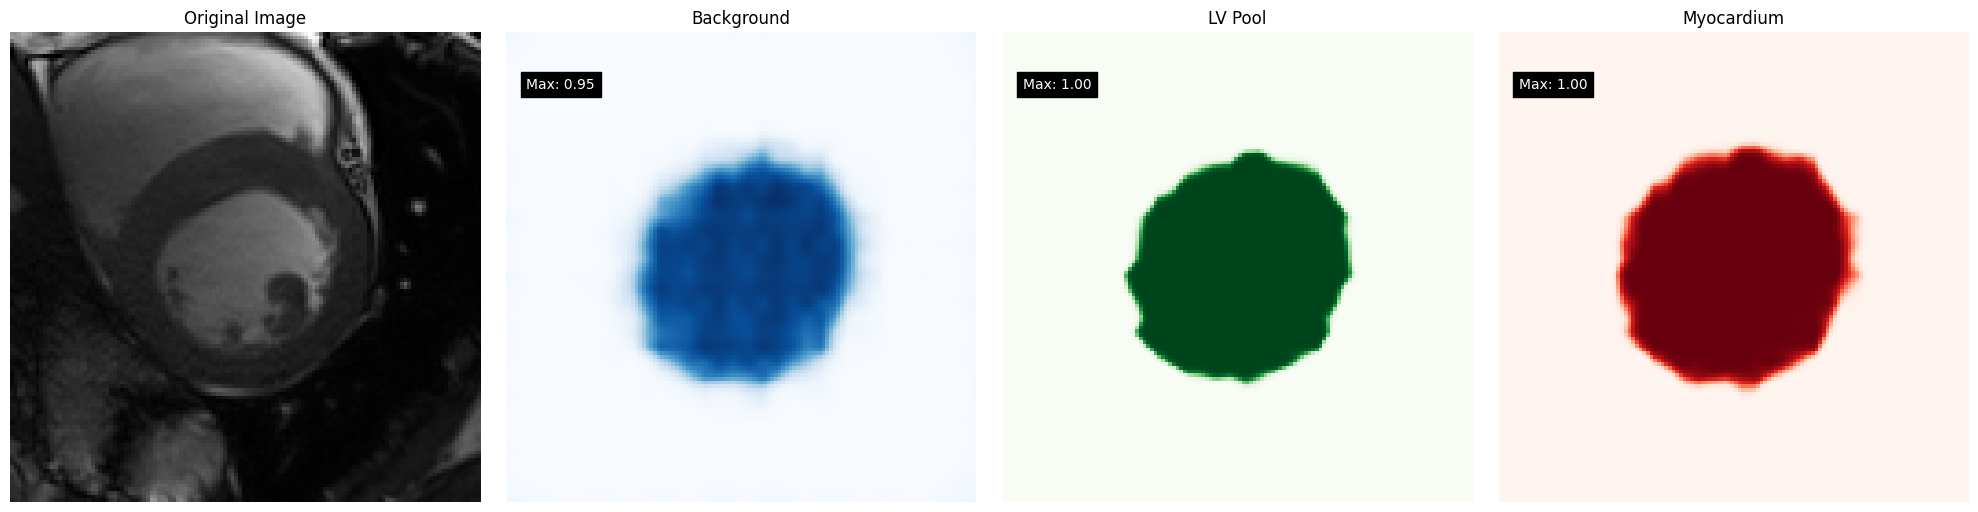

In [50]:
import matplotlib.pyplot as plt
import torch
import numpy as np



# 1. 确保剥离梯度并转换为概率
# 假设 final_masks 来自模型输出
# 如果 final_masks 是 [1, 3, 128, 128]，先 squeeze(0) 去掉 batch 维度
if final_masks.dim() == 4:
    final_masks = final_masks.squeeze(0)

probs = torch.sigmoid(final_masks).detach().cpu().numpy()

# 此时 probs 应该是 (3, 128, 128)
print(f"可视化数据形状 (Probs Shape): {probs.shape}")

# 2. 获取底图
img_bg = batch_data["image"].squeeze().cpu().numpy()
if img_bg.ndim == 3: # 处理 [3, 1024, 1024]
    img_bg = img_bg[0]

# 3. 绘图配置
labels = ['Background', 'LV Pool', 'Myocardium']
cmaps = ['gray', 'Blues', 'Greens', 'Reds']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 第一张：底图
axes[0].imshow(img_bg, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# 后面三张：循环打印每个类别通道
for i in range(3):
    # 强制确保传入的是 (128, 128)
    channel_data = probs[i].squeeze() 
    
    im = axes[i+1].imshow(channel_data, cmap=cmaps[i+1])
    axes[i+1].set_title(labels[i])
    axes[i+1].axis('off')
    
    # 打印置信度
    max_p = np.max(channel_data)
    axes[i+1].text(5, 15, f"Max: {max_p:.2f}", color='white', 
                   backgroundcolor='black', fontsize=10)

plt.tight_layout()
plt.show()

In [51]:
import torch
import numpy as np

print(f" 模型输出形状 (Final Masks Shape): {final_masks.shape}")
num_output_channels = final_masks.shape[1] if final_masks.dim() == 4 else final_masks.shape[0]
print(f" 模型输出了 {num_output_channels} 个通道")

# 2. 检查真值 (Ground Truth) 到底有几个类
# 从 DataLoader 再拿一个 batch
batch_temp = next(iter(dl))
gt_mask_temp = batch_temp["mask"]
unique_values = torch.unique(gt_mask_temp).numpy()

print(f" 真实标签包含的值 (Unique Values in GT): {unique_values}")
print(f" 数据实际上有 {len(unique_values)} 个类别")

# 3. 智能判断
if len(unique_values) > num_output_channels:
    print(" 警告：数据的类别数 > 模型输出通道数！你会丢掉部分类别（比如右心室）！")
elif len(unique_values) == 4 and 3 in unique_values:
    print(" 发现 4 个类别 (0,1,2,3)！如果你只想要 LV 和 Myo，请确认代码是否做了映射。")
    print("   通常顺序是: 0-背景, 1-右心室, 2-心肌, 3-左心室")
else:
    print(" 数据与模型通道数看起来是匹配的 (含背景)。")

 模型输出形状 (Final Masks Shape): torch.Size([3, 128, 128])
 模型输出了 3 个通道
 真实标签包含的值 (Unique Values in GT): [0. 1. 2.]
 数据实际上有 3 个类别
 数据与模型通道数看起来是匹配的 (含背景)。


 你的 Ground Truth 里包含这些数值: [0. 1. 2.]
也就是说，你一共有 3 个类别 (含背景)


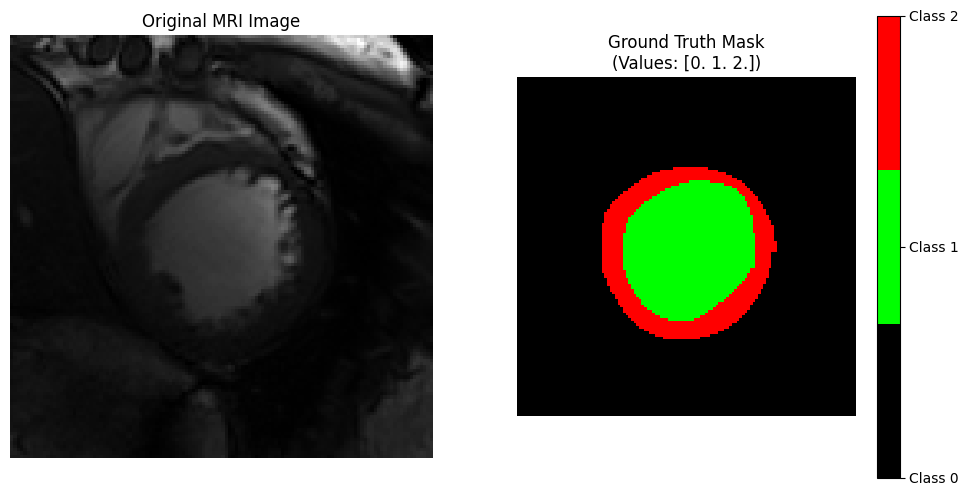

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import ListedColormap

# 1. 从数据加载器里随机抽查一个 Batch
# 注意：每次运行这一行，都会随机换一张图
try:
    batch_check = next(iter(dl))
except:
    # 如果 dl 已经跑空了，重新生成迭代器
    batch_check = next(iter(torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True)))

# 2. 提取第一张图和对应的 Mask
img_show = batch_check['image'][0].squeeze().cpu().numpy() # 底图
mask_show = batch_check['mask'][0].squeeze().cpu().numpy() # 真值 Mask

# 3. 关键步骤：检查 Mask 里的数值！
unique_vals = np.unique(mask_show)
print(f" 你的 Ground Truth 里包含这些数值: {unique_vals}")
print(f"也就是说，你一共有 {len(unique_vals)} 个类别 (含背景)")

# 4. 可视化配置
colors = ['black', 'lime', 'red', 'cyan', 'yellow']
# 根据你的实际类别数截取颜色
cmap_gt = ListedColormap(colors[:len(unique_vals)]) if len(unique_vals) < 5 else 'jet'

# 5. 画图对比
# 假设 img_show 是从 Tensor 转过来的 numpy 数组
# 形状可能是 (3, 128, 128)

# 如果是 (3, H, W)，我们就只取第一个通道，变成 (H, W)
if img_show.ndim == 3 and img_show.shape[0] == 3:
    img_show = img_show[0] 

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 左边：原始 MRI
axes[0].imshow(img_show, cmap='gray')
axes[0].set_title("Original MRI Image")
axes[0].axis('off')

# 右边：... (你原本的代码)

# 右边：Ground Truth (真值)
im = axes[1].imshow(mask_show, cmap=cmap_gt, interpolation='nearest')
axes[1].set_title(f"Ground Truth Mask\n(Values: {unique_vals})")
axes[1].axis('off')

# 加个颜色条对应一下
cbar = plt.colorbar(im, ax=axes[1], ticks=unique_vals)
cbar.ax.set_yticklabels([f"Class {int(v)}" for v in unique_vals])

plt.show()